In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import pyplot

%matplotlib inline

In [2]:
# load data
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

In [3]:
print(train_df.shape)
print(test_df.shape)

(9366, 18)
(4801, 17)


In [4]:
train_df.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return
0,PF00001002,DSK00001001,OFF00001002,B,20040720,110000000.0,T,0.02074,USD,2.332216,1.098097e+08,20040720,NaN,20040812,B,NaN,NaN,0.02496
1,PF00001003,DSK00001002,OFF00001001,A,20040709,176671000.0,N,0.02074,GBP,5.269617,1.760084e+08,20040723,NaN,20040812,C,NaN,NaN,0.05496
2,PF00001005,DSK00001004,OFF00001001,A,20040723,56474000.0,T,0.02074,USD,2.332216,5.637953e+07,20040723,NaN,20040817,A,NaN,NaN,0.02496
3,PF00001006,DSK00001005,OFF00001001,A,20040609,164813000.0,T,0.02074,USD,2.332216,1.645088e+08,20040723,NaN,20040713,A,NaN,NaN,0.02496
4,PF00001007,DSK00001005,OFF00001002,B,20040609,140800000.0,T,0.02074,USD,2.332216,1.405402e+08,20040723,NaN,20040713,B,NaN,NaN,0.02496


In [5]:
all_df = pd.concat([train_df, test_df])
print(all_df.shape)

(14167, 18)


In [6]:
from sklearn.preprocessing import LabelEncoder as LabelEncoder

le_contry_code = LabelEncoder().fit(all_df['country_code'])
le_office_id = LabelEncoder().fit(all_df['office_id'])
le_pf_category = LabelEncoder().fit(all_df['pf_category'])
le_currency = LabelEncoder().fit(all_df['currency'])
le_type = LabelEncoder().fit(all_df['type'])

In [7]:
all_df['country_code_enc'] = le_contry_code.transform(all_df['country_code'])
all_df['office_id_enc'] = le_office_id.transform(all_df['office_id'])
all_df['pf_category_enc'] = le_pf_category.transform(all_df['pf_category'])
all_df['currency_enc'] = le_currency.transform(all_df['currency'])
all_df['type_enc'] = le_type.transform(all_df['type'])

In [8]:
all_df['creation_date'] = pd.to_datetime(all_df['creation_date'], format='%Y%m%d')
all_df['sell_date'] = pd.to_datetime(all_df['sell_date'], format='%Y%m%d')
all_df['duration'] = all_df['sell_date'] - all_df['creation_date']
all_df['duration'] = all_df['duration'].apply(lambda x: x.days)

In [9]:
from datetime import date
a = pd.Timestamp(date(2004, 7, 1))

#all_df['creation_delta_days'] = all_df.apply(lambda x: (x['creation_date'] - a).days, axis=1)
all_df['sell_date_delta_days'] = all_df.apply(lambda x: (x['sell_date'] - a).days, axis=1)

In [10]:
all_df['indicator_code'] = all_df['indicator_code'].fillna(False)
all_df['indicator_code'] = all_df['indicator_code'] * 1

In [11]:
all_df['status'] = all_df['status'].fillna(False)
all_df['status'] = all_df['status'] * 1

In [12]:
all_df['hedge_value'] = all_df['hedge_value'].fillna(-1) 
all_df['hedge_value'] = all_df['hedge_value'] * 1

In [13]:
all_df['sold_ratio'] = all_df['bought'] / all_df['sold']

In [14]:
train_df = all_df[:9366]
test_df = all_df[9366:]

print(train_df.shape)
print(test_df.shape)

(9366, 26)
(4801, 26)


In [15]:
numeric_features = test_df.columns
numeric_features = numeric_features.drop(['creation_date', 'sell_date'])
numeric_features = numeric_features.drop(['country_code', 'pf_category', 'currency', 'type'])
numeric_features = numeric_features.drop(['portfolio_id', 'desk_id', 'office_id', 'return'])
numeric_features = numeric_features.drop(['bought', 'sold'])

In [16]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(train_df[numeric_features].as_matrix(), 
                                                      train_df['return'].as_matrix(),
                                                      test_size=0.2,
                                                      random_state=42)
                                                                
print(train_X.shape)
print(valid_X.shape)                                           
print(train_y.shape)
print(valid_y.shape)

(7492, 14)
(1874, 14)
(7492,)
(1874,)


In [17]:
from catboost import CatBoostRegressor

In [31]:
def getModel(depth=7, lr=0.02, border_count=128, verbose=True):
    model = CatBoostRegressor(iterations=1000, 
                              verbose=verbose, 
                              depth=depth, 
                              learning_rate=lr,
                              border_count=border_count,
                              od_type='Iter',
                              od_wait=30)
    return model

In [32]:
model = getModel(border_count=32, depth=6, lr=0.5)

C:\opt\Anaconda3\lib\site-packages\catboost\core.py:1529: FutureWarning: The 'verbose' parameter is deprecated, use 'logging_level' parameter instead (posible values: 'Silent', 'Verbose', 'Info', 'Debug').
  super(CatBoostRegressor, self).__init__(params)


In [33]:
fit_model = model.fit(train_X, train_y, eval_set=(valid_X, valid_y))

0: learn: 0.01318544	test: 0.02226361	bestTest: 0.02226361 (0)	total: 56.4ms	remaining: 56.4s
1: learn: 0.00839475	test: 0.01981894	bestTest: 0.01981894 (1)	total: 106ms	remaining: 53s
2: learn: 0.006262545	test: 0.01886368	bestTest: 0.01886368 (2)	total: 156ms	remaining: 51.8s
3: learn: 0.005179522	test: 0.01854564	bestTest: 0.01854564 (3)	total: 214ms	remaining: 53.3s
4: learn: 0.004661029	test: 0.018403	bestTest: 0.018403 (4)	total: 272ms	remaining: 54.2s
5: learn: 0.004352884	test: 0.01833878	bestTest: 0.01833878 (5)	total: 322ms	remaining: 53.3s
6: learn: 0.004132316	test: 0.01829	bestTest: 0.01829 (6)	total: 372ms	remaining: 52.7s
7: learn: 0.003997127	test: 0.01826187	bestTest: 0.01826187 (7)	total: 421ms	remaining: 52.2s
8: learn: 0.003912859	test: 0.01825206	bestTest: 0.01825206 (8)	total: 479ms	remaining: 52.8s
9: learn: 0.003632085	test: 0.01822426	bestTest: 0.01822426 (9)	total: 581ms	remaining: 57.5s
10: learn: 0.003515796	test: 0.0181969	bestTest: 0.0181969 (10)	total: 69

In [34]:
y_predict = fit_model.predict(valid_X)

In [35]:
from sklearn.metrics import r2_score as r2_score

In [36]:
r2_score(valid_y, y_predict)

# 0.48550769455517873
# 0.48824042779607291
# 0.49111170421523154
# 0.51344678397675569
# 0.5173075327419292
# 0.52126008495345544

0.52126008495345544

# Feature importance

In [37]:
feature_importance_df = pd.DataFrame()
feature_importance_df['name'] = numeric_features
feature_importance_df['value'] = model.get_feature_importance(valid_X, valid_y)
feature_importance_df = feature_importance_df.sort_values(by=['value'])

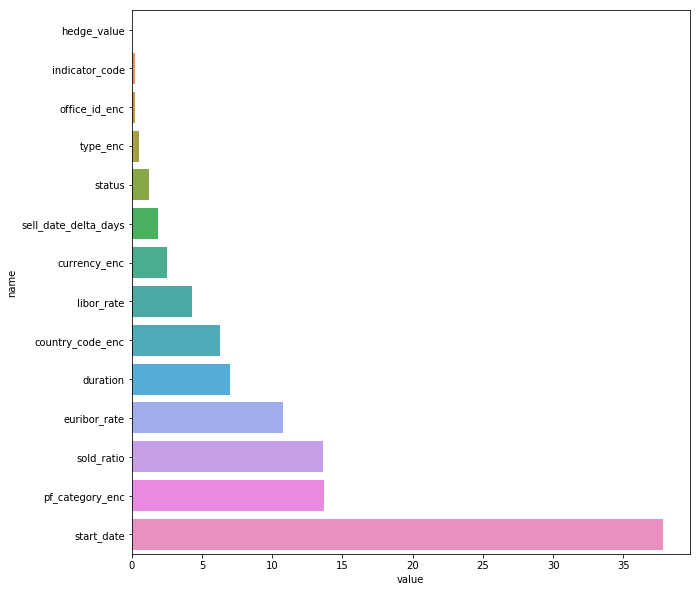

In [38]:
fig, ax = pyplot.subplots(figsize=(10,10))
sns.barplot(ax=ax, x=feature_importance_df['value'], y=feature_importance_df['name']);

In [39]:
feature_importance_df

,name,value
1,hedge_value,0.002915
2,indicator_code,0.192814
7,office_id_enc,0.200224
10,type_enc,0.500305
5,status,1.210378
12,sell_date_delta_days,1.855237
9,currency_enc,2.490030
3,libor_rate,4.314102
6,country_code_enc,6.282116
11,duration,6.995690


# Criar CSV para submissão

In [40]:
y_predict = fit_model.predict(test_df[numeric_features])

In [41]:
sample_submission_df = pd.DataFrame()

sample_submission_df['portfolio_id'] = test_df['portfolio_id']
sample_submission_df['return'] = y_predict
sample_submission_df.head()

,portfolio_id,return
0,PF00001001,0.028090
1,PF00001004,0.024348
2,PF00001009,0.023272
3,PF00001013,0.025380
4,PF00001014,0.027350


In [42]:
sample_submission_df.to_csv('submission2.csv', index=False)